In [ ]:
# @title Import Requirements
from IPython.display import clear_output
import os
import io
import gc
import random
import nltk

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tsnecuda import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import pairwise_distances
from scipy.stats import spearmanr, pearsonr
from scipy.stats import entropy

import tensorflow as tf
from tqdm.notebook import tqdm

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

from transformers import (
    BertConfig,
    BertTokenizer,
    TFBertForSequenceClassification
)

SELECTED_GPU = 1
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_visible_devices(gpus[SELECTED_GPU], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[SELECTED_GPU], True)
    print(gpus[SELECTED_GPU])
  except RuntimeError as e:
    print(e)


PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


In [ ]:
fdir = '/home/username/NLP/Data/SentEval/data/probing/'
BATCH_SIZE = 256
MAX_LENGTH = 48

TASK_NAME = 'past_present.txt'

pretrained_loc = "bert-base-uncased"
print("Running with:", pretrained_loc)

Running with: bert-base-uncased


In [ ]:
# @title Required Functions & Classes
def load_probing_data(fpath, additive=''):
    task_data = {'train': {'X': [], 'y': []},
                 'dev': {'X': [], 'y': []},
                 'test': {'X': [], 'y': []}}


    tok2split = {'tr': 'train', 'va': 'dev', 'te': 'test'}
    with io.open(fpath, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.rstrip().split('\t')
            task_data[tok2split[line[0]]]['X'].append(additive + line[-1])
            task_data[tok2split[line[0]]]['y'].append(line[1])

        if fpath == '~/NLP/Data/SentEval/data/probing/tree_depth.txt':
            labels = ['5', '6', '7', '8', '9', '10', '11']
            tok2label = dict(zip(labels, [0, 1. / 6, 2. / 6, 3. / 6, 4. / 6, 5. / 6, 1]))
        else:
            labels = sorted(np.unique(task_data['train']['y']))
            tok2label = dict(zip(labels, range(len(labels))))
        nclasses = len(tok2label)

        for split in task_data:
            for i, y in enumerate(task_data[split]['y']):
                task_data[split]['y'][i] = tok2label[y]

    return task_data, tok2label, nclasses

class BertReprProbing(tf.keras.Model):
    def __init__(self, bert_model, **kwargs):
        super(BertReprProbing, self).__init__(name="BertReprProbing")
        self.bert = bert_model

    def call(self, inputs, **kwargs):
        middle_hidden_states = self.bert(inputs, **kwargs)[2]
        output = []
        for i in range(1, 13):
            output.append(middle_hidden_states[i])
        return tf.stack(output)

@tf.function
def tf_average(hidden_states, att_mask, w):
  max_length = tf.cast(tf.shape(att_mask)[1], tf.float32)
  att_mask = tf.cast(att_mask[:, 1:], tf.float32)
  avg = tf.reshape(tf.matmul(tf.transpose(hidden_states[:, 1:] * tf.expand_dims(att_mask, axis=-1), perm=[0, 2, 1]), w), (-1, 768))
  avg = avg * tf.cast((max_length - 1.0) / tf.reduce_sum(att_mask, axis=-1, keepdims=True), tf.float32)
  return avg

In [ ]:
# @title Load BERT Model
config = BertConfig.from_pretrained(pretrained_loc, output_hidden_states=True)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
loaded_model = TFBertForSequenceClassification.from_pretrained(pretrained_loc,
                                                               config=config)

probing_model = BertReprProbing(loaded_model.bert)
clear_output()
print("Done!")

Done!


In [ ]:
#@title Probe Feature Extraction (Total)
probe_path = fdir + TASK_NAME
task_data, tok2label, nclasses = load_probing_data(probe_path)
print("Probe Loaded:", TASK_NAME)

del task_data['train']
del task_data['dev']
gc.collect()


n_total_examples = len(task_data['test']['X'])
total_steps = int(np.ceil(n_total_examples / BATCH_SIZE))

total_hidden_representations = np.zeros((12, n_total_examples, MAX_LENGTH, 768), dtype=np.float32)
total_token_ids = np.zeros((n_total_examples, MAX_LENGTH), dtype=np.int32)
total_att_masks = np.zeros((n_total_examples, MAX_LENGTH), dtype=np.int32)

print("Starting probe feature extraction:", TASK_NAME)

for i in tqdm(range(total_steps)):
    tokens_batched = tokenizer.batch_encode_plus(task_data['test']['X'][i * BATCH_SIZE:min((i + 1) * BATCH_SIZE, n_total_examples)],
                                                 max_length=MAX_LENGTH,
                                                 return_tensors='tf',
                                                 truncation=True,
                                                 padding='max_length')
    
    total_hidden_representations[:,
    i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :, :] = probing_model(tokens_batched, training=False).numpy()

    total_att_masks[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['attention_mask']
    total_token_ids[i * BATCH_SIZE:(i + 1) * BATCH_SIZE, :] = tokens_batched['input_ids']                                 

Probe Loaded: past_present.txt
Starting probe feature extraction: past_present.txt


In [ ]:
# @title Importance Computation 2 Function
def compute_importance(n_examples, hidden_representations, att_masks, label, classifier_model_fpath):
  saliances = np.zeros((12, n_examples, nclasses, MAX_LENGTH))
  gold_importance = np.empty((12, n_examples, MAX_LENGTH))
  weights = tf.Variable(np.ones((MAX_LENGTH-1, 1)) / (MAX_LENGTH-1), dtype=tf.float32, trainable=True)
  pred_labels = np.zeros((12, n_examples))
  accuracy = np.zeros(12)

  BATCH_SIZE = 128
  steps = int(np.ceil(n_examples / BATCH_SIZE))
  for i in range(12):
    # print("Load classifier", i)
    classifier = tf.keras.models.load_model(classifier_model_fpath + TASK_NAME[:-4] + '/' + str(i))
    acc = 0.0
    for j in range(steps):
      with tf.GradientTape() as tape:
        avgs = tf_average(hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :],
                          att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], weights)
        probs = classifier(avgs)[:, 0]
      grads = tape.gradient(probs, avgs)
      pred_labels[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE] = probs < 0.5
      salience_scores = tf.expand_dims(grads, axis=1) * hidden_representations[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, :] * tf.cast(tf.expand_dims(att_masks[j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :], axis=-1), dtype=tf.float32)
      saliances[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:] = tf.reduce_sum(salience_scores, axis=-1).numpy()[:, 1:]
      saliances[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 1, 1:] = -saliances[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, 0, 1:]
      
      acc += np.mean(pred_labels[i, j * BATCH_SIZE:(j + 1) * BATCH_SIZE] == label[j * BATCH_SIZE:(j + 1) * BATCH_SIZE])
      # importance[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :, 1:] = tf.squeeze(grads, axis=-1)
      # rep_importance[i][j * BATCH_SIZE:(j + 1) * BATCH_SIZE, :] = grads_rep_based
    # print(acc / steps)
    accuracy[i] = acc / steps

  
  for i in range(n_examples):
    gold_importance[:, i] = saliances[:, i, label[i]]
  return saliances, gold_importance, accuracy, pred_labels
      

In [ ]:
CLASSIFIER_MODEL_FPATH_100K_BASE = '/home/username/NLP/Projects/SentEval/Training/saved_classifier_control_full_'
CLASSIFIER_MODEL_FPATH_1K_BASE = '/home/username/NLP/Projects/SentEval/Training/saved_classifier_control_10K_'


In [ ]:
# @title compute correlations
accuracies_100k = np.zeros((3, 12))
accuracies_1k = np.zeros((3, 12))

pearsons = np.zeros((3, 12))
spearmans = np.zeros((3, 12))

for seed in range(3):
  # 100k
  _, impo_100k, acc_100k, _ = compute_importance(n_total_examples, total_hidden_representations, total_att_masks, task_data['test']['y'], CLASSIFIER_MODEL_FPATH_100K_BASE+str(seed+1)+'/')
  accuracies_100k[seed] = acc_100k
  # 1k
  _, impo_1k, acc_1k, _ = compute_importance(n_total_examples, total_hidden_representations, total_att_masks, task_data['test']['y'], CLASSIFIER_MODEL_FPATH_1K_BASE+str(seed+1)+'/')
  accuracies_1k[seed] = acc_1k

  for l in range(12):
    for ex in range(n_total_examples):
      P = impo_100k[l][ex][1:np.sum(total_att_masks[ex])] # remove cls and pad tokens
      Q = impo_1k[l][ex][1:np.sum(total_att_masks[ex])] # remove cls and pad tokens

      # Correlations
      pearsons[seed][l] = pearsonr(P, Q)[0]
      spearmans[seed][l] = spearmanr(P, Q)[0]



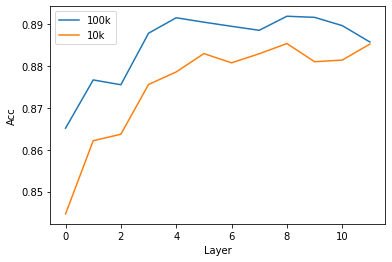

In [ ]:
# @title performance scores
plt.plot(np.mean(accuracies_100k, axis=0), label='100k')
plt.plot(np.mean(accuracies_1k, axis=0), label='10k')
plt.ylabel('Acc')
plt.xlabel('Layer')
plt.legend()
plt.show()

###Pearson

In [ ]:
print(np.mean(np.mean(pearsons, axis=1)))
print(np.mean(np.max(pearsons, axis=1)))

0.8471550509547673
0.9317797147635162


###Sperman

In [ ]:
print(np.mean(np.mean(spearmans, axis=1)))
print(np.mean(np.max(spearmans, axis=1)))

0.6706959706959706
0.9120879120879121
